In [3]:
import pandas as pd # dataframe manipulation
import numpy as np # linear algebra

# data visualization
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
import shap

# sklearn 
from sklearn.cluster import KMeans
from sklearn.preprocessing import PowerTransformer, OrdinalEncoder
from sklearn.pipeline import Pipeline
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score, silhouette_samples, accuracy_score, classification_report

from pyod.models.ecod import ECOD
from yellowbrick.cluster import KElbowVisualizer

import lightgbm as lgb
import prince

from kmodes.kprototypes import KPrototypes
from plotnine import *
import plotnine

In [7]:
df = pd.read_csv("../../cleaned_data_v2.csv")

df['lot_size_category'] = pd.qcut(df['sqft_lot'], q=3, labels=False)
df['grade_living_category'] = pd.qcut(df['grade_living'], q=3, labels=False)
df['bedrooms_cat'] = df['bedrooms'].apply(lambda x: '>4' if x>4 else '<3' if x<3 else '3-4')

selected_columns = [
    'bedrooms_cat', 'lot_size_category', 'floors', 'view', 
    'condition', 'bathroom_category', 'is_near_shore', 'grade_living_category'
]

df_selected = df[selected_columns]
df_selected

bedrooms_cat  lot_size_category  floors  view  condition  \
0              3-4                  0     1.0     0          3   
1              3-4                  1     2.0     0          3   
2               <3                  2     1.0     0          3   
3              3-4                  0     1.0     0          5   
4              3-4                  1     1.0     0          3   
...            ...                ...     ...   ...        ...   
21608          3-4                  0     3.0     0          3   
21609          3-4                  0     2.0     0          3   
21610           <3                  0     2.0     0          3   
21611          3-4                  0     2.0     0          3   
21612           <3                  0     2.0     0          3   

          bathroom_category  is_near_shore  grade_living_category  
0      Studio or 1 Bathroom          False                      0  
1             2-3 Bathrooms          False                      2  
2      Studio or 1 Bathroom          False                      0  
3             2-3 Bathrooms           True                      1  
4             1-2 Bathrooms          False                      1  
...                     ...            ...                    ...  
21608         2-3 Bathrooms          False                      1  
21609         2-3 Bathrooms          False                      2  
21610  Studio or 1 Bathroom          False                      0  
21611         2-3 Bathrooms          False                      1  
21612  Studio or 1 Bathroom          False                      0  

[21613 rows x 8 columns]

<h1> Preprocessing </h1>

In [35]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from kmodes.kprototypes import KPrototypes
from sklearn.base import BaseEstimator, TransformerMixin



# Define categorical and numerical features
categorical_features = ['bedrooms_cat', 'condition', 'bathroom_category', 'lot_size_category','view','grade_living_category']
numerical_features = ['floors']
boolean_features = ['is_near_shore']


class NoTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X

# Modify the categorical_transformer to do nothing
categorical_transformer2 = Pipeline(steps=[
    ('noop', NoTransformer())
])

# Define transformers for each type of feature
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

numerical_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

class BooleanEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, boolean_features):
        self.boolean_features = boolean_features

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X.astype(int)

    def get_feature_names_out(self, input_features=None):
        return self.boolean_features

# Update the ColumnTransformer to use the custom BooleanEncoder
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, categorical_features),
        ('num', numerical_transformer, numerical_features),
        ('bool', BooleanEncoder(boolean_features), boolean_features)  # Use the custom BooleanEncoder
    ]
)

# Create a pipeline that includes the preprocessor and the k-prototypes clustering algorithm
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor)])

# Assuming you have already defined and fitted your pipeline
pipe_fit = pipeline.fit(df_selected)

# Get the column names after one-hot encoding for categorical features
transformed_categorical_columns = pipe_fit.named_steps['preprocessor'].named_transformers_['cat'] \
    .named_steps['onehot'].get_feature_names_out(input_features=categorical_features)

# Get the names of boolean features
boolean_features_transformed = pipe_fit.named_steps['preprocessor'].named_transformers_['bool'] \
    .get_feature_names_out()

# Adjust the boolean feature names to match the transformed feature columns
adjusted_boolean_feature_names = [f'is_near_shore_{val}' for val in boolean_features]

# Concatenate the column names for categorical and boolean features
transformed_columns = np.concatenate([transformed_categorical_columns, numerical_features,adjusted_boolean_feature_names])

# Concatenate the transformed data with the original numerical data
transformed_data = pipe_fit.transform(df_selected)
data = pd.DataFrame(transformed_data, columns=transformed_columns)
data

bedrooms_cat_3-4  bedrooms_cat_<3  bedrooms_cat_>4  condition_1  \
0                   1.0              0.0              0.0          0.0   
1                   1.0              0.0              0.0          0.0   
2                   0.0              1.0              0.0          0.0   
3                   1.0              0.0              0.0          0.0   
4                   1.0              0.0              0.0          0.0   
...                 ...              ...              ...          ...   
21608               1.0              0.0              0.0          0.0   
21609               1.0              0.0              0.0          0.0   
21610               0.0              1.0              0.0          0.0   
21611               1.0              0.0              0.0          0.0   
21612               0.0              1.0              0.0          0.0   

       condition_2  condition_3  condition_4  condition_5  \
0              0.0          1.0          0.0          0.0   
1              0.0          1.0          0.0          0.0   
2              0.0          1.0          0.0          0.0   
3              0.0          0.0          0.0          1.0   
4              0.0          1.0          0.0          0.0   
...            ...          ...          ...          ...   
21608          0.0          1.0          0.0          0.0   
21609          0.0          1.0          0.0          0.0   
21610          0.0          1.0          0.0          0.0   
21611          0.0          1.0          0.0          0.0   
21612          0.0          1.0          0.0          0.0   

       bathroom_category_+3 Bathrooms  bathroom_category_1-2 Bathrooms  \
0                                 0.0                              0.0   
1                                 0.0                              0.0   
2                                 0.0                              0.0   
3                                 0.0                              0.0   
4                                 0.0                              1.0   
...                               ...                              ...   
21608                             0.0                              0.0   
21609                             0.0                              0.0   
21610                             0.0                              0.0   
21611                             0.0                              0.0   
21612                             0.0                              0.0   

       bathroom_category_2-3 Bathrooms  \
0                                  0.0   
1                                  1.0   
2                                  0.0   
3                                  1.0   
4                                  0.0   
...                                ...   
21608                              1.0   
21609                              1.0   
21610                              0.0   
21611                              1.0   
21612                              0.0   

       bathroom_category_Studio or 1 Bathroom  lot_size_category_0  \
0                                         1.0                  1.0   
1                                         0.0                  0.0   
2                                         1.0                  0.0   
3                                         0.0                  1.0   
4                                         0.0                  0.0   
...                                       ...                  ...   
21608                                     0.0                  1.0   
21609                                     0.0                  1.0   
21610                                     1.0                  1.0   
21611                                     0.0                  1.0   
21612                                     1.0                  1.0   

       lot_size_category_1  lot_size_category_2  view_0  view_1  view_2  \
0                      0.0                  0.0     1.0     0.0     0.0   


In [10]:
# show all col
pd.set_option('display.max_columns', None)

<h1> Get Outliers </h1>

In [38]:
from pyod.models.ecod import ECOD
# https://github.com/yzhao062/pyod
clf = ECOD()
clf.fit(data)
outliers = clf.predict(data) 

df_selected["outliers"] = outliers

df_no_outliers = df_selected[df_selected["outliers"] == 0]
df_no_outliers = df_no_outliers.drop(["outliers"], axis = 1)

/var/folders/m7/snhszr993kscmjx9dwlff1lm0000gn/T/ipykernel_25708/3677030292.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [39]:
df_no_outliers

bedrooms_cat  lot_size_category  floors  view  condition  \
0              3-4                  0     1.0     0          3   
1              3-4                  1     2.0     0          3   
2               <3                  2     1.0     0          3   
3              3-4                  0     1.0     0          5   
4              3-4                  1     1.0     0          3   
...            ...                ...     ...   ...        ...   
21608          3-4                  0     3.0     0          3   
21609          3-4                  0     2.0     0          3   
21610           <3                  0     2.0     0          3   
21611          3-4                  0     2.0     0          3   
21612           <3                  0     2.0     0          3   

          bathroom_category  is_near_shore  grade_living_category  
0      Studio or 1 Bathroom          False                      0  
1             2-3 Bathrooms          False                      2  
2      Studio or 1 Bathroom          False                      0  
3             2-3 Bathrooms           True                      1  
4             1-2 Bathrooms          False                      1  
...                     ...            ...                    ...  
21608         2-3 Bathrooms          False                      1  
21609         2-3 Bathrooms          False                      2  
21610  Studio or 1 Bathroom          False                      0  
21611         2-3 Bathrooms          False                      1  
21612  Studio or 1 Bathroom          False                      0  

[19437 rows x 8 columns]

Dataset normalized without onehot preprocessing. Get the numeric features to modify their scale


In [15]:
# pipe = Pipeline([('scaler', PowerTransformer())])

# df_aux = pd.DataFrame(pipe_fit.fit_transform(df_no_outliers[["age", "balance"]] ), columns = ["age", "balance"])
# df_no_outliers_norm = df_no_outliers.copy()

# # Replace age and balance columns by preprocessed values
# df_no_outliers_norm = df_no_outliers_norm.drop(["age", "balance"], axis = 1)
# df_no_outliers_norm["age"] = df_aux["age"].values
# df_no_outliers_norm["balance"] = df_aux["balance"].values
# df_no_outliers_norm

job  marital  education default housing loan       age  \
0        management  married   tertiary      no     yes   no  1.593554   
1        technician   single  secondary      no     yes   no  0.476098   
2      entrepreneur  married  secondary      no     yes  yes -0.731532   
3       blue-collar  married    unknown      no     yes   no  0.743482   
5        management  married   tertiary      no     yes   no -0.475239   
...             ...      ...        ...     ...     ...  ...       ...   
45202        admin.   single  secondary      no      no   no -0.600614   
45204       retired  married  secondary      no      no   no  2.538978   
45206    technician  married   tertiary      no      no   no  1.073369   
45209   blue-collar  married  secondary      no      no   no  1.523015   
45210  entrepreneur  married  secondary      no      no   no -0.238887   

        balance  
0      1.109265  
1     -0.898751  
2     -0.958550  
3      0.756726  
5     -0.518504  
...         ...  
45202 -0.065297  
45204  1.395571  
45206  0.220663  
45209  0.060384  
45210  1.435096  

[40691 rows x 8 columns]

In [41]:
df_no_outliers

bedrooms_cat  lot_size_category  floors  view  condition  \
0              3-4                  0     1.0     0          3   
1              3-4                  1     2.0     0          3   
2               <3                  2     1.0     0          3   
3              3-4                  0     1.0     0          5   
4              3-4                  1     1.0     0          3   
...            ...                ...     ...   ...        ...   
21608          3-4                  0     3.0     0          3   
21609          3-4                  0     2.0     0          3   
21610           <3                  0     2.0     0          3   
21611          3-4                  0     2.0     0          3   
21612           <3                  0     2.0     0          3   

          bathroom_category  is_near_shore  grade_living_category  
0      Studio or 1 Bathroom          False                      0  
1             2-3 Bathrooms          False                      2  
2      Studio or 1 Bathroom          False                      0  
3             2-3 Bathrooms           True                      1  
4             1-2 Bathrooms          False                      1  
...                     ...            ...                    ...  
21608         2-3 Bathrooms          False                      1  
21609         2-3 Bathrooms          False                      2  
21610  Studio or 1 Bathroom          False                      0  
21611         2-3 Bathrooms          False                      1  
21612  Studio or 1 Bathroom          False                      0  

[19437 rows x 8 columns]

DataSet with onehot preprocessing AND normalized

In [20]:
data["outliers"] = outliers
data_no_outliers = data[data["outliers"] == 0]
data_no_outliers = data_no_outliers.drop(["outliers"], axis = 1)

Optimal number of cluster (be careful, it takes a long time)

We get the index of categorical columns

In [18]:
# numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']

# categorical_columns = df_no_outliers_norm.select_dtypes(exclude=numerics).columns
# print(categorical_columns)
# categorical_columns_index = [df_no_outliers_norm.columns.get_loc(col) for col in categorical_columns]

Index(['job', 'marital', 'education', 'default', 'housing', 'loan'], dtype='object')


In [43]:
# scale floor column  df_no_outliers without pipeline
scaler = StandardScaler()
df_no_outliers_scaled = df_no_outliers.copy()
df_no_outliers_scaled['floors'] = scaler.fit_transform(df_no_outliers_scaled[['floors']])


In [46]:
categorical_columns_index = [df_no_outliers_scaled.columns.get_loc(col) for col in categorical_features] 
categorical_columns_index.append(6)
categorical_columns_index

[0, 4, 5, 1, 3, 7, 6]

In [47]:
df_no_outliers_scaled

bedrooms_cat  lot_size_category    floors  view  condition  \
0              3-4                  0 -0.917282     0          3   
1              3-4                  1  0.956124     0          3   
2               <3                  2 -0.917282     0          3   
3              3-4                  0 -0.917282     0          5   
4              3-4                  1 -0.917282     0          3   
...            ...                ...       ...   ...        ...   
21608          3-4                  0  2.829530     0          3   
21609          3-4                  0  0.956124     0          3   
21610           <3                  0  0.956124     0          3   
21611          3-4                  0  0.956124     0          3   
21612           <3                  0  0.956124     0          3   

          bathroom_category  is_near_shore  grade_living_category  
0      Studio or 1 Bathroom          False                      0  
1             2-3 Bathrooms          False                      2  
2      Studio or 1 Bathroom          False                      0  
3             2-3 Bathrooms           True                      1  
4             1-2 Bathrooms          False                      1  
...                     ...            ...                    ...  
21608         2-3 Bathrooms          False                      1  
21609         2-3 Bathrooms          False                      2  
21610  Studio or 1 Bathroom          False                      0  
21611         2-3 Bathrooms          False                      1  
21612  Studio or 1 Bathroom          False                      0  

[19437 rows x 8 columns]

Cluster initiation: 2
Cluster initiation: 3
Cluster initiation: 4
Cluster initiation: 5
Cluster initiation: 6
Cluster initiation: 7
Cluster initiation: 8
Cluster initiation: 9
Cluster initiation: 10
Cluster initiation: 11
Cluster initiation: 12
Cluster initiation: 13
Cluster initiation: 14


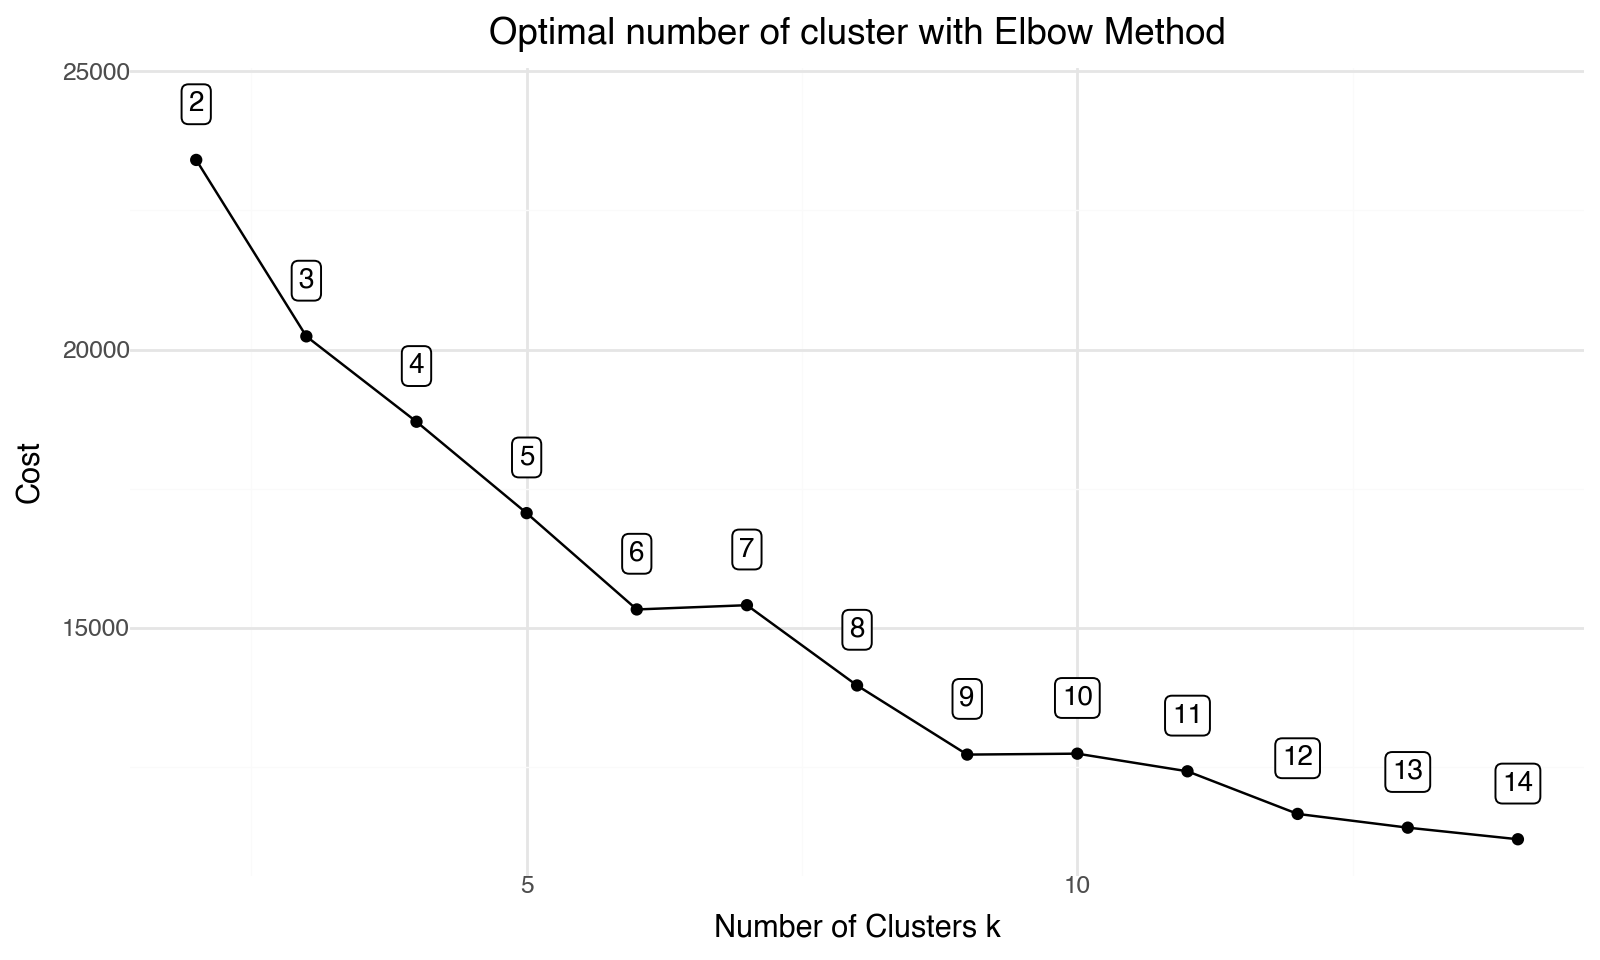

In [50]:
# Choose optimal K using Elbow method

cost = []
range_ = range(2, 15)
for cluster in range_:
 
        kprototype = KPrototypes(n_jobs = -1, n_clusters = cluster, init = 'Huang', random_state = 0)
        kprototype.fit_predict(df_no_outliers_scaled, categorical = categorical_columns_index)
        cost.append(kprototype.cost_)
        print('Cluster initiation: {}'.format(cluster))
 
# Converting the results into a dataframe and plotting them
df_cost = pd.DataFrame({'Cluster':range_, 'Cost':cost})
# Data viz
plotnine.options.figure_size = (8, 4.8)
(
    ggplot(data = df_cost)+
    geom_line(aes(x = 'Cluster',
                  y = 'Cost'))+
    geom_point(aes(x = 'Cluster',
                   y = 'Cost'))+
    geom_label(aes(x = 'Cluster',
                   y = 'Cost',
                   label = 'Cluster'),
               size = 10,
               nudge_y = 1000) +
    labs(title = 'Optimal number of cluster with Elbow Method')+
    xlab('Number of Clusters k')+
    ylab('Cost')+
    theme_minimal()
)

![Alt text](img/kpropotype_no_out.png)

<h1> We are going to use k=5 and Kpropotype, This model allows us to use mixed dataframes (numeric and categorical variables)   </h1>

In [20]:
# https://github.com/MaxHalford/prince

In [51]:
df_no_outliers_scaled

bedrooms_cat  lot_size_category    floors  view  condition  \
0              3-4                  0 -0.917282     0          3   
1              3-4                  1  0.956124     0          3   
2               <3                  2 -0.917282     0          3   
3              3-4                  0 -0.917282     0          5   
4              3-4                  1 -0.917282     0          3   
...            ...                ...       ...   ...        ...   
21608          3-4                  0  2.829530     0          3   
21609          3-4                  0  0.956124     0          3   
21610           <3                  0  0.956124     0          3   
21611          3-4                  0  0.956124     0          3   
21612           <3                  0  0.956124     0          3   

          bathroom_category  is_near_shore  grade_living_category  
0      Studio or 1 Bathroom          False                      0  
1             2-3 Bathrooms          False                      2  
2      Studio or 1 Bathroom          False                      0  
3             2-3 Bathrooms           True                      1  
4             1-2 Bathrooms          False                      1  
...                     ...            ...                    ...  
21608         2-3 Bathrooms          False                      1  
21609         2-3 Bathrooms          False                      2  
21610  Studio or 1 Bathroom          False                      0  
21611         2-3 Bathrooms          False                      1  
21612  Studio or 1 Bathroom          False                      0  

[19437 rows x 8 columns]

In [64]:
from sklearn.metrics import silhouette_score
import numpy as np

cluster_num = 4

# Fit KPrototypes model
kprototype = KPrototypes(n_jobs=-1, n_clusters=cluster_num, init='Huang', random_state=0)
kprototype.fit(df_no_outliers_scaled, categorical=categorical_columns_index)

# Predict cluster labels
clusters = kprototype.predict(df_no_outliers_scaled, categorical=categorical_columns_index)

# Calculate silhouette score
silhouette_avg = silhouette_score(df_no_outliers_scaled, clusters)
print("Silhouette Score:", silhouette_avg)

# Analyze cluster distribution
cluster_distribution = np.bincount(clusters)
print("Cluster Distribution:", cluster_distribution)

# Optionally, you can analyze the characteristics of each cluster
for cluster_label in range(cluster_num):
    cluster_data = df_no_outliers_scaled[clusters == cluster_label]
    print("Cluster", cluster_label)
    print("Size:", len(cluster_data))
    print("Mean values:")
    print(cluster_data.mean(axis=0))
    print("-" * 20)


ValueError: could not convert string to float: '3-4'

In [53]:
df_no_outliers_norm = df_no_outliers_scaled.copy()

In [54]:
clusters

array([0, 1, 0, ..., 1, 1, 1], dtype=uint16)

In [55]:
# Cluster centorid
print(kprototype.cluster_centroids_)
# Check the iteration of the clusters created
print(kprototype.n_iter_)
# Check the cost of the clusters created
print(kprototype.cost_)

[['-0.7584266495286109' '3-4' '3' 'Studio or 1 Bathroom' '1' '0' '0'
  'False']
 ['1.0411782180002658' '3-4' '3' '2-3 Bathrooms' '0' '0' '2' 'False']
 ['-0.8366261248503469' '3-4' '3' '1-2 Bathrooms' '2' '0' '1' 'False']]
3
20235.987711576072


In [56]:
from prince import MCA

def get_MCA_3d(df, predict):

    mca = MCA(n_components =3, n_iter = 100, random_state = 101)

    mca_3d_df = mca.fit_transform(df)
    mca_3d_df.columns = ["comp1", "comp2", "comp3"]
    mca_3d_df["cluster"] = predict

    return mca, mca_3d_df



def get_MCA_2d(df, predict):

    mca = MCA(n_components =2, n_iter = 100, random_state = 101)

    mca_2d_df = mca.fit_transform(df)
    mca_2d_df.columns = ["comp1", "comp2"]
    mca_2d_df["cluster"] = predict

    return mca, mca_2d_df

mca_3d, mca_3d_df = get_MCA_3d(df_no_outliers_norm, clusters)

In [57]:
mca_3d_df

comp1     comp2     comp3  cluster
0      0.600036  0.509852 -0.103067        0
1     -0.635081  0.061665 -0.196083        1
2      0.864906  0.583504 -0.635230        0
3      0.002426 -0.195963  1.029520        2
4      0.217703 -0.508348  0.255228        2
...         ...       ...       ...      ...
21608 -0.297383  0.678584  1.306866        1
21609 -0.677038  0.389894  0.085826        1
21610  0.567516  1.155282 -0.215494        1
21611 -0.464176  0.215315  0.501352        1
21612  0.567516  1.155282 -0.215494        1

[19437 rows x 4 columns]

In [58]:
mca_3d.eigenvalues_summary

eigenvalue % of variance % of variance (cumulative)
component                                                    
0              0.313        10.89%                     10.89%
1              0.201         7.01%                     17.90%
2              0.175         6.10%                     24.00%

In [59]:
def get_pca_2d(df, predict):

    pca_2d_object = prince.PCA(
    n_components=2,
    n_iter=3,
    rescale_with_mean=True,
    rescale_with_std=True,
    copy=True,
    check_input=True,
    engine='sklearn',
    random_state=42
    )

    pca_2d_object.fit(df)

    df_pca_2d = pca_2d_object.transform(df)
    df_pca_2d.columns = ["comp1", "comp2"]
    df_pca_2d["cluster"] = predict

    return pca_2d_object, df_pca_2d



def get_pca_3d(df, predict):

    pca_3d_object = prince.PCA(
    n_components=3,
    n_iter=3,
    rescale_with_mean=True,
    rescale_with_std=True,
    copy=True,
    check_input=True,
    engine='sklearn',
    random_state=42
    )

    pca_3d_object.fit(df)

    df_pca_3d = pca_3d_object.transform(df)
    df_pca_3d.columns = ["comp1", "comp2", "comp3"]
    df_pca_3d["cluster"] = predict

    return pca_3d_object, df_pca_3d



def plot_pca_3d(df, title = "PCA Space", opacity=0.8, width_line = 0.1):

    df = df.astype({"cluster": "object"})
    df = df.sort_values("cluster")

    fig = px.scatter_3d(df, 
                        x='comp1', 
                        y='comp2', 
                        z='comp3',
                        color='cluster',
                        template="plotly",
                        
                        # symbol = "cluster",
                        
                        color_discrete_sequence=px.colors.qualitative.Vivid,
                        title=title).update_traces(
                            # mode = 'markers',
                            marker={
                                "size": 4,
                                "opacity": opacity,
                                # "symbol" : "diamond",
                                "line": {
                                    "width": width_line,
                                    "color": "black",
                                }
                            }
                        ).update_layout(
                                width = 1000, 
                                height = 800, 
                                autosize = False, 
                                showlegend = True,
                                legend=dict(title_font_family="Times New Roman",
                                            font=dict(size= 20)),
                                scene = dict(xaxis=dict(title = 'comp1', titlefont_color = 'black'),
                                            yaxis=dict(title = 'comp2', titlefont_color = 'black'),
                                            zaxis=dict(title = 'comp3', titlefont_color = 'black')),
                                font = dict(family = "Gilroy", color  = 'black', size = 15))
                      
    
    fig.show()


def plot_pca_2d(df, title = "PCA Space", opacity=0.8, width_line = 0.1):

    df = df.astype({"cluster": "object"})
    df = df.sort_values("cluster")

    fig = px.scatter(df, 
                        x='comp1', 
                        y='comp2', 
                        color='cluster',
                        template="plotly",
                        # symbol = "cluster",
                        
                        color_discrete_sequence=px.colors.qualitative.Vivid,
                        title=title).update_traces(
                            # mode = 'markers',
                            marker={
                                "size": 8,
                                "opacity": opacity,
                                # "symbol" : "diamond",
                                "line": {
                                    "width": width_line,
                                    "color": "black",
                                }
                            }
                        ).update_layout(
                                width = 800, 
                                height = 700, 
                                autosize = False, 
                                showlegend = True,
                                legend=dict(title_font_family="Times New Roman",
                                            font=dict(size= 20)),
                                scene = dict(xaxis=dict(title = 'comp1', titlefont_color = 'black'),
                                            yaxis=dict(title = 'comp2', titlefont_color = 'black'),
                                            ),
                                font = dict(family = "Gilroy", color  = 'black', size = 15))
                        
        
    fig.show()




In [60]:
plot_pca_3d(mca_3d_df, title="MCA Space", opacity=1, width_line = 0.1)

![Alt text](img/kpro2.png)

In [61]:
mca_2d, mca_2d_df = get_MCA_2d(df_no_outliers_norm, clusters)

In [62]:
plot_pca_2d(mca_3d_df, title="MCA Space", opacity=1, width_line = 0.5)

![Alt text](img/kpro1.png)

<h1> We can obtain the components of the PCA analysis and represent the identified clusters by the kprototype algorithm
</h1>

In [63]:
pca_3d_object, df_pca_3d = get_pca_3d(data_no_outliers, clusters)
plot_pca_3d(df_pca_3d, title = "PCA Space", opacity=1, width_line = 0.1)
print("The variability is :", pca_3d_object.eigenvalues_summary)

The variability is :           eigenvalue % of variance % of variance (cumulative)
component                                                    
0              3.366        13.46%                     13.46%
1              2.476         9.90%                     23.37%
2              1.994         7.97%                     31.34%


In [33]:
pca_2d_object, df_pca_2d = get_pca_2d(data_no_outliers, clusters)
plot_pca_2d(df_pca_2d, title = "PCA Space", opacity=1, width_line = 0.5)


<h1> Features importance </h1>

[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.155616 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 346
[LightGBM] [Info] Number of data points in the train set: 40691, number of used features: 8
[LightGBM] [Info] Start training from score -1.288309
[LightGBM] [Info] Start training from score -1.737218
[LightGBM] [Info] Start training from score -1.627316
[LightGBM] [Info] Start training from score -1.949529
[LightGBM] [Info] Start training from score -1.563239
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


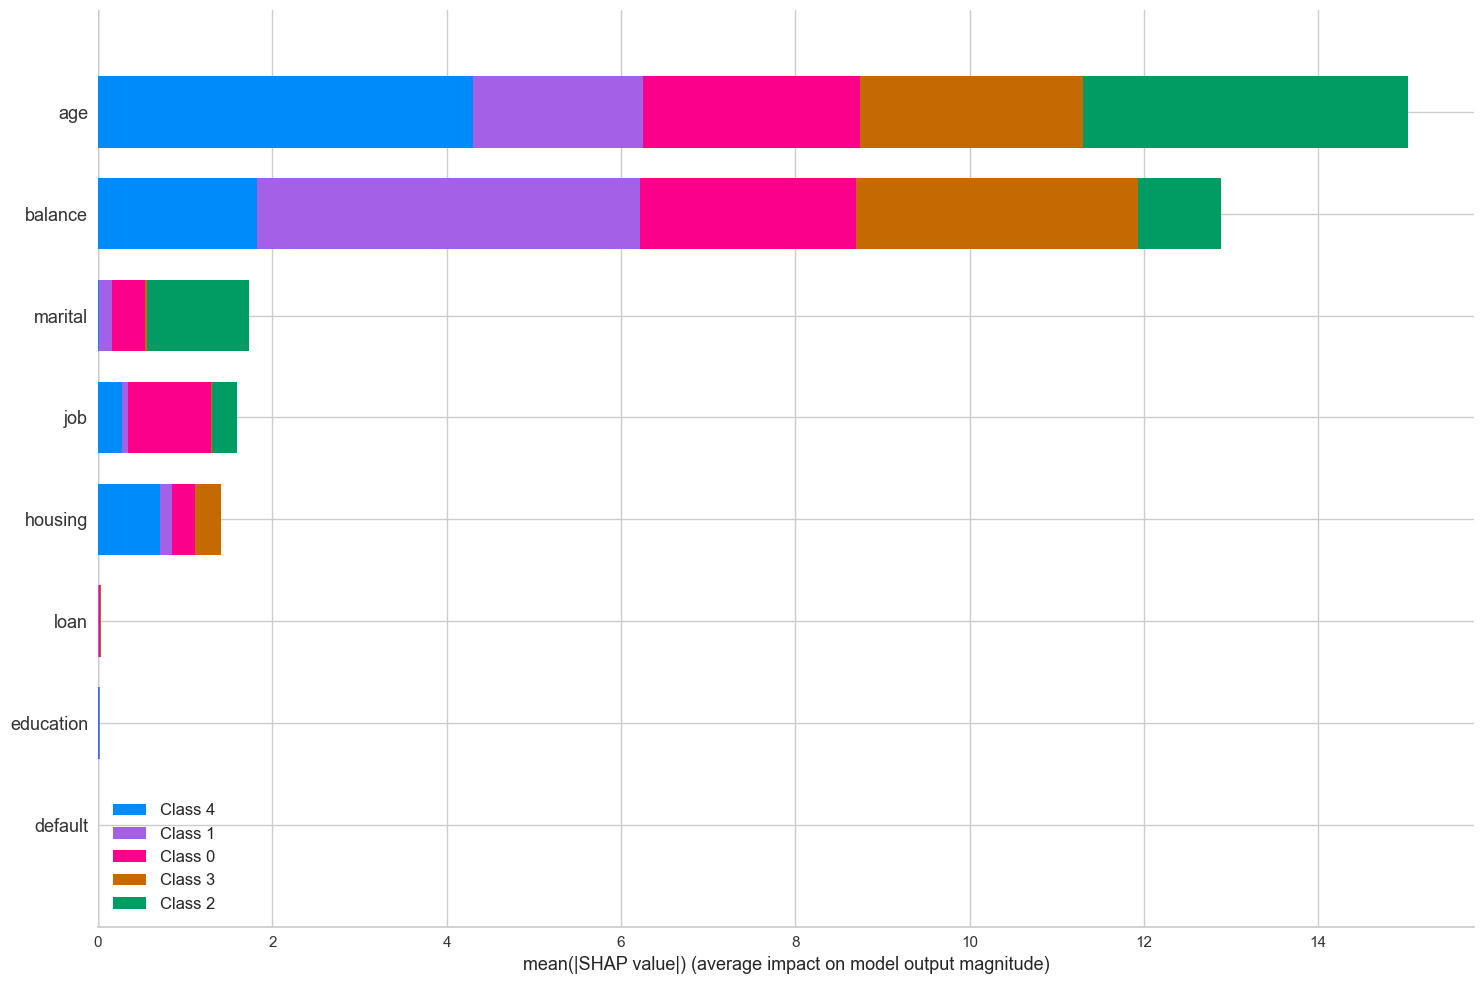

In [34]:
import lightgbm as lgb
import shap


clf_km = lgb.LGBMClassifier(colsample_by_tree=0.8)



for col in ["job", "marital", "education", "housing", "loan", "default"]:
    df_no_outliers_norm[col] = df_no_outliers_norm[col].astype('category')


clf_km.fit(X = df_no_outliers_norm , y = clusters, feature_name = "auto", categorical_feature = "auto")
# clf_km.fit(X = df_prueba, y = predict_embedding, feature_name='auto', categorical_feature = 'auto')
#SHAP values
explainer_km = shap.TreeExplainer(clf_km)
shap_values_km = explainer_km.shap_values(df_no_outliers_norm)
shap.summary_plot(shap_values_km, df_no_outliers_norm, plot_type="bar", plot_size=(15, 10))

In [35]:
df_no_outliers = df[df.outliers == 0]
df_no_outliers["cluster"] = clusters

df_no_outliers.groupby('cluster').agg(
    {
         'age':'mean',
        'balance': 'mean',
       
        'job': lambda x: x.value_counts().index[0],
        'marital': lambda x: x.value_counts().index[0],
        'education': lambda x: x.value_counts().index[0],
        'housing': lambda x: x.value_counts().index[0],
        'loan': lambda x: x.value_counts().index[0],
        'default': lambda x: x.value_counts().index[0],
        
    }
).sort_values("balance").reset_index()

C:\Users\damia\AppData\Local\Temp\ipykernel_16396\2279410345.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



cluster        age      balance          job  marital  education housing  \
0        0  38.017558   176.943316  blue-collar  married  secondary     yes   
1        4  51.554500   302.270679   management  married  secondary      no   
2        2  29.730673   391.930198   management   single  secondary     yes   
3        1  35.107512  3089.760262   management  married  secondary     yes   
4        3  51.142783  3101.546961   management  married  secondary      no   

  loan default  
0   no      no  
1   no      no  
2   no      no  
3   no      no  
4   no      no

# k means

In [70]:
from pyod.models.ecod import ECOD
# https://github.com/yzhao062/pyod
clf = ECOD()
clf.fit(data)
outliers = clf.predict(data) 

df_selected["outliers"] = outliers
index = (df_selected["outliers"] == 0)
df_kmeans = data[index]
df_kmeans

/var/folders/m7/snhszr993kscmjx9dwlff1lm0000gn/T/ipykernel_25708/2388984334.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



bedrooms_cat_3-4  bedrooms_cat_<3  bedrooms_cat_>4  condition_1  \
0                   1.0              0.0              0.0          0.0   
1                   1.0              0.0              0.0          0.0   
2                   0.0              1.0              0.0          0.0   
3                   1.0              0.0              0.0          0.0   
4                   1.0              0.0              0.0          0.0   
...                 ...              ...              ...          ...   
21608               1.0              0.0              0.0          0.0   
21609               1.0              0.0              0.0          0.0   
21610               0.0              1.0              0.0          0.0   
21611               1.0              0.0              0.0          0.0   
21612               0.0              1.0              0.0          0.0   

       condition_2  condition_3  condition_4  condition_5  \
0              0.0          1.0          0.0          0.0   
1              0.0          1.0          0.0          0.0   
2              0.0          1.0          0.0          0.0   
3              0.0          0.0          0.0          1.0   
4              0.0          1.0          0.0          0.0   
...            ...          ...          ...          ...   
21608          0.0          1.0          0.0          0.0   
21609          0.0          1.0          0.0          0.0   
21610          0.0          1.0          0.0          0.0   
21611          0.0          1.0          0.0          0.0   
21612          0.0          1.0          0.0          0.0   

       bathroom_category_+3 Bathrooms  bathroom_category_1-2 Bathrooms  \
0                                 0.0                              0.0   
1                                 0.0                              0.0   
2                                 0.0                              0.0   
3                                 0.0                              0.0   
4                                 0.0                              1.0   
...                               ...                              ...   
21608                             0.0                              0.0   
21609                             0.0                              0.0   
21610                             0.0                              0.0   
21611                             0.0                              0.0   
21612                             0.0                              0.0   

       bathroom_category_2-3 Bathrooms  \
0                                  0.0   
1                                  1.0   
2                                  0.0   
3                                  1.0   
4                                  0.0   
...                                ...   
21608                              1.0   
21609                              1.0   
21610                              0.0   
21611                              1.0   
21612                              0.0   

       bathroom_category_Studio or 1 Bathroom  lot_size_category_0  \
0                                         1.0                  1.0   
1                                         0.0                  0.0   
2                                         1.0                  0.0   
3                                         0.0                  1.0   
4                                         0.0                  0.0   
...                                       ...                  ...   
21608                                     0.0                  1.0   
21609                                     0.0                  1.0   
21610                                     1.0                  1.0   
21611                                     0.0                  1.0   
21612                                     1.0                  1.0   

       lot_size_category_1  lot_size_category_2  view_0  view_1  view_2  \
0                      0.0                  0.0     1.0     0.0     0.0   


In [71]:
# scale floor in df|_kmeans
scaler = StandardScaler()
df_kmeans_scaled = df_kmeans.copy()
df_kmeans_scaled['floors'] = scaler.fit_transform(df_kmeans_scaled[['floors']])
df_kmeans_scaled


bedrooms_cat_3-4  bedrooms_cat_<3  bedrooms_cat_>4  condition_1  \
0                   1.0              0.0              0.0          0.0   
1                   1.0              0.0              0.0          0.0   
2                   0.0              1.0              0.0          0.0   
3                   1.0              0.0              0.0          0.0   
4                   1.0              0.0              0.0          0.0   
...                 ...              ...              ...          ...   
21608               1.0              0.0              0.0          0.0   
21609               1.0              0.0              0.0          0.0   
21610               0.0              1.0              0.0          0.0   
21611               1.0              0.0              0.0          0.0   
21612               0.0              1.0              0.0          0.0   

       condition_2  condition_3  condition_4  condition_5  \
0              0.0          1.0          0.0          0.0   
1              0.0          1.0          0.0          0.0   
2              0.0          1.0          0.0          0.0   
3              0.0          0.0          0.0          1.0   
4              0.0          1.0          0.0          0.0   
...            ...          ...          ...          ...   
21608          0.0          1.0          0.0          0.0   
21609          0.0          1.0          0.0          0.0   
21610          0.0          1.0          0.0          0.0   
21611          0.0          1.0          0.0          0.0   
21612          0.0          1.0          0.0          0.0   

       bathroom_category_+3 Bathrooms  bathroom_category_1-2 Bathrooms  \
0                                 0.0                              0.0   
1                                 0.0                              0.0   
2                                 0.0                              0.0   
3                                 0.0                              0.0   
4                                 0.0                              1.0   
...                               ...                              ...   
21608                             0.0                              0.0   
21609                             0.0                              0.0   
21610                             0.0                              0.0   
21611                             0.0                              0.0   
21612                             0.0                              0.0   

       bathroom_category_2-3 Bathrooms  \
0                                  0.0   
1                                  1.0   
2                                  0.0   
3                                  1.0   
4                                  0.0   
...                                ...   
21608                              1.0   
21609                              1.0   
21610                              0.0   
21611                              1.0   
21612                              0.0   

       bathroom_category_Studio or 1 Bathroom  lot_size_category_0  \
0                                         1.0                  1.0   
1                                         0.0                  0.0   
2                                         1.0                  0.0   
3                                         0.0                  1.0   
4                                         0.0                  0.0   
...                                       ...                  ...   
21608                                     0.0                  1.0   
21609                                     0.0                  1.0   
21610                                     1.0                  1.0   
21611                                     0.0                  1.0   
21612                                     1.0                  1.0   

       lot_size_category_1  lot_size_category_2  view_0  view_1  view_2  \
0                      0.0                  0.0     1.0     0.0     0.0   


In [74]:
from sklearn.cluster import KMeans
from sklearn.model_selection import GridSearchCV

# Define a custom scoring function for silhouette score
def silhouette_scorer(estimator, X):
    labels = estimator.fit_predict(X)
    return silhouette_score(X, labels)

# Define the parameter grid
param_grid = {
    'n_clusters': [2, 3, 4, 5],  # Number of clusters to try
    'init': ['k-means++', 'random'],  # Initialization method
    'n_init': [10, 20, 30],  # Number of initializations to try
    'max_iter': [300, 400, 500]  # Maximum number of iterations
}

# Create KMeans instance
kmeans = KMeans()

# Create GridSearchCV instance
grid_search = GridSearchCV(kmeans, param_grid, cv=5, scoring=silhouette_scorer, n_jobs=-1)

# Perform grid search
grid_search.fit(df_kmeans_scaled)

# Get the best parameters and the best silhouette score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Best Parameters:", best_params)
print("Best Silhouette Score:", best_score)


Best Parameters: {'init': 'k-means++', 'max_iter': 300, 'n_clusters': 2, 'n_init': 10}
Best Silhouette Score: 0.2641060698891483
